# Phase 4 Project - Time Series Modeling Introduction

### By Rachel Beery

## Overview

### In this project we are using a time series model to understand the patterns of natural disasters declarations in the United States. By understanding these patterns we will then provide recommendations on what natural disasters to prepare for and when they may occur. 

Source: https://www.fema.gov/openfema-data-page/disaster-declarations-summaries-v2 

In [1]:
# We will begin by importing all of the packages we anticipate to use
import pandas as pd
import pandas.tseries  
import numpy as np  

import statsmodels.api as sm 
import itertools

import matplotlib.pyplot as plt   
from matplotlib.pylab import rcParams 
%matplotlib inline
plt.style.use('ggplot') 
import plotly.express as px
import plotly.figure_factory as ff 
import plotly.graph_objects as go 
import seaborn as sns  

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Setting the display defaults
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows',)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:

#Import data and see the headers
df = pd.read_csv(r"DisasterDeclarationsSummaries.csv")
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02T04:00:00.000Z,1953,Tornado,TORNADO,0,1,1,1,1953-05-02T04:00:00.000Z,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15T04:00:00.000Z,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15T04:00:00.000Z,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06T04:00:00.000Z,1953,Flood,FLOODS,0,1,1,1,1953-06-06T04:00:00.000Z,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11T04:00:00.000Z,1953,Tornado,TORNADO,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11T04:00:00.000Z,1953,Flood,FLOOD,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [4]:
# How big is this dataset?
df.shape

(60440, 23)

In [5]:
# Looking to make sure out df is the correct datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60440 entries, 0 to 60439
Data columns (total 23 columns):
femaDeclarationString       60440 non-null object
disasterNumber              60440 non-null int64
state                       60440 non-null object
declarationType             60440 non-null object
declarationDate             60440 non-null object
fyDeclared                  60440 non-null int64
incidentType                60440 non-null object
declarationTitle            60440 non-null object
ihProgramDeclared           60440 non-null int64
iaProgramDeclared           60440 non-null int64
paProgramDeclared           60440 non-null int64
hmProgramDeclared           60440 non-null int64
incidentBeginDate           60440 non-null object
incidentEndDate             52339 non-null object
disasterCloseoutDate        43789 non-null object
fipsStateCode               60440 non-null int64
fipsCountyCode              60440 non-null int64
placeCode                   60440 non-null int64


In [6]:
df.describe()

,disasterNumber,fyDeclared,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,fipsStateCode,fipsCountyCode,placeCode,declarationRequestNumber
count,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000,60440.000
mean,2474.543,2003.302,0.165,0.284,0.932,0.354,31.534,97.294,96489.649,35849.570
std,1376.038,14.591,0.372,0.451,0.252,0.478,16.601,102.835,13747.325,35830.568
min,1.000,1953.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,3.000
25%,1249.000,1996.000,0.000,0.000,1.000,0.000,19.000,31.000,99029.000,8099.000
50%,2704.500,2005.000,0.000,0.000,1.000,0.000,30.000,75.000,99073.000,19026.000
75%,3458.000,2016.000,0.000,1.000,1.000,1.000,46.000,127.000,99123.000,76022.000
max,5383.000,2021.000,1.000,1.000,1.000,1.000,78.000,840.000,99507.000,99159.000


In [7]:
# Do we have nulls?
df.isna().sum()

femaDeclarationString           0
disasterNumber                  0
state                           0
declarationType                 0
declarationDate                 0
fyDeclared                      0
incidentType                    0
declarationTitle                0
ihProgramDeclared               0
iaProgramDeclared               0
paProgramDeclared               0
hmProgramDeclared               0
incidentBeginDate               0
incidentEndDate              8101
disasterCloseoutDate        16651
fipsStateCode                   0
fipsCountyCode                  0
placeCode                       0
designatedArea                  0
declarationRequestNumber        0
hash                            0
lastRefresh                     0
id                              0
dtype: int64

In [8]:
# Do we have any duplicate rows?
duplicates = df[df.duplicated()]
print(len(duplicates))
duplicates.head()
# None

0


,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id


In [9]:
# Clean the nulls
# incidentEndDate and disasterCloseoutDate are the only values with nulls

(10, -0.5)

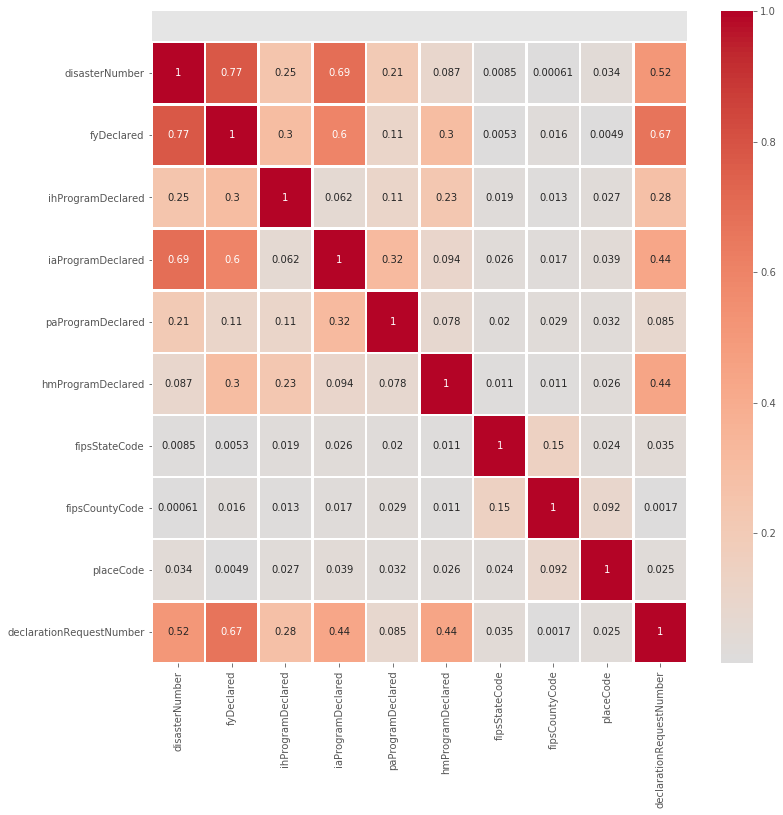

In [10]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr().abs(), center=0, annot=True, linewidths=1.5, cmap='coolwarm');
ax.set_ylim(len(df.corr())-0, -0.5)

# Scrub

In [11]:
df['femaDeclarationString'].value_counts()

DR-4522-ME    437
DR-1239-TX    257
EM-3458-TX    257
DR-4485-TX    257
EM-3261-TX    255
             ... 
FM-2552-CA      1
DR-172-MT       1
EM-3507-WA      1
DR-125-WV       1
EM-3363-TX      1
Name: femaDeclarationString, Length: 4497, dtype: int64

In [12]:
df['disasterNumber'].value_counts()

4522    437
3458    257
4485    257
1239    257
3261    255
       ... 
2993      1
5010      1
2961      1
2929      1
2049      1
Name: disasterNumber, Length: 4497, dtype: int64

In [13]:
df['state'].value_counts()

TX    4651
MO    2670
VA    2460
KY    2416
OK    2278
GA    2239
LA    2131
FL    2027
NC    1965
PR    1825
IA    1823
MS    1691
KS    1682
AL    1619
AR    1588
TN    1522
MN    1498
IN    1451
CA    1443
NE    1423
NY    1421
ND    1301
OH    1281
IL    1268
SD    1251
PA    1226
WV    1218
ME    1004
WI     891
WA     862
SC     855
MI     791
CO     642
MT     586
NJ     567
OR     562
NM     495
MD     445
MA     389
ID     346
AZ     323
VT     314
NH     294
NV     271
AK     247
UT     241
CT     228
WY     128
RI     102
HI      95
VI      79
AS      75
MP      62
MH      53
DE      52
FM      31
DC      22
GU      19
PW       1
Name: state, dtype: int64

In [14]:
df['declarationType'].value_counts()

DR    40964
EM    17696
FM     1780
Name: declarationType, dtype: int64

In [15]:
df['declarationDate'].value_counts()

2020-03-13T20:00:00.000Z    2876
2020-03-13T19:00:00.000Z     566
1996-01-13T05:00:00.000Z     453
2020-04-04T17:15:00.000Z     437
2005-09-13T17:34:00.000Z     433
                            ... 
2006-09-17T04:40:00.000Z       1
2004-08-21T06:05:00.000Z       1
1982-08-19T04:00:00.000Z       1
2006-08-12T04:37:00.000Z       1
2004-07-04T03:27:00.000Z       1
Name: declarationDate, Length: 3849, dtype: int64

In [16]:
df['declarationDate'] = df['declarationDate'].str.split('T').str[0]

In [17]:
df['declarationDate'].value_counts()

2020-03-13    3683
2005-09-11     777
2020-04-04     738
2005-09-05     646
2005-09-13     615
              ... 
2019-10-28       1
1991-07-03       1
2002-02-12       1
2000-05-30       1
1993-06-18       1
Name: declarationDate, Length: 3118, dtype: int64

In [18]:
df['declarationDate'] = pd.to_datetime(df['declarationDate'])

In [19]:
# df['Declaration Day of Week'] = df['declarationDate'].dt.day_name()

In [20]:
#df['Declaration Year'] = df['declarationDate'].dt.year
#df['Declaration Month'] = df['declarationDate'].dt.month
#df['Declaration Day'] = df['declarationDate'].dt.day

In [21]:
#df = df.drop(columns=['declarationDate'], axis=1)

In [22]:
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02T04:00:00.000Z,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15T04:00:00.000Z,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06T04:00:00.000Z,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11T04:00:00.000Z,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [23]:
df['fyDeclared'].value_counts()

2020    9243
2005    4661
2011    2684
2008    2456
2019    1902
        ... 
1960      13
1961      11
1953      10
1959       7
1958       6
Name: fyDeclared, Length: 69, dtype: int64

In [24]:
df['incidentType'].value_counts()

Severe Storm(s)     16957
Hurricane           11890
Flood               10389
Biological           7611
Snow                 3659
Fire                 3488
Severe Ice Storm     1990
Tornado              1464
Drought              1292
Coastal Storm         570
Freezing              301
Other                 297
Earthquake            226
Typhoon               130
Volcano                51
Fishing Losses         42
Mud/Landslide          31
Dam/Levee Break        13
Tsunami                 9
Chemical                9
Toxic Substances        9
Human Cause             7
Terrorist               5
Name: incidentType, dtype: int64

In [25]:
df['declarationTitle'].value_counts()

COVID-19 PANDEMIC               3928
SEVERE STORMS AND FLOODING      3810
COVID-19                        3683
SEVERE STORMS & FLOODING        3387
HURRICANE KATRINA EVACUATION    2602
                                ... 
TYPHOON KAREN                      1
TYPHOON LOLA                       1
KAWAIHAE ROAD FIRE HAWAII          1
ANGORA FIRE                        1
CA-CROWN WILDFIRE-07-21-2004       1
Name: declarationTitle, Length: 2136, dtype: int64

In [26]:
# We can combine COVID into one category as it's listed as two different categories
df['declarationTitle'].replace('COVID-19', 'COVID-19 PANDEMIC', inplace=True)
df['declarationTitle'].replace('SEVERE STORMS & FLOODING', 'SEVERE STORMS AND FLOODING', inplace=True)
df['declarationTitle'].value_counts()

COVID-19 PANDEMIC                         7611
SEVERE STORMS AND FLOODING                7197
HURRICANE KATRINA EVACUATION              2602
SEVERE WINTER STORM                       1935
SEVERE STORMS, TORNADOES, AND FLOODING    1849
                                          ... 
TYPHOON LOLA                                 1
KAWAIHAE ROAD FIRE HAWAII                    1
ANGORA FIRE                                  1
CO - SPRING FIRE - 06/03/02                  1
CA-CROWN WILDFIRE-07-21-2004                 1
Name: declarationTitle, Length: 2134, dtype: int64

In [27]:
#df = df.set_index("declarationTitle")
#df= df.drop('COVID-19 PANDEMIC', axis=0)

In [28]:
df['ihProgramDeclared'].value_counts()

0    50440
1    10000
Name: ihProgramDeclared, dtype: int64

In [29]:
df['iaProgramDeclared'].value_counts()

0    43253
1    17187
Name: iaProgramDeclared, dtype: int64

In [30]:
df['paProgramDeclared'].value_counts()

1    56309
0     4131
Name: paProgramDeclared, dtype: int64

In [31]:
df['hmProgramDeclared'].value_counts()

0    39029
1    21411
Name: hmProgramDeclared, dtype: int64

In [32]:
df['incidentBeginDate'].value_counts()

2020-01-20T19:00:00.000Z    7310
2005-08-29T04:00:00.000Z    1959
1993-03-13T05:00:00.000Z     771
1996-01-06T05:00:00.000Z     415
2005-11-27T05:00:00.000Z     380
                            ... 
1982-09-22T04:00:00.000Z       1
2014-05-20T04:00:00.000Z       1
2006-01-12T05:00:00.000Z       1
1990-12-16T05:00:00.000Z       1
2017-07-07T04:00:00.000Z       1
Name: incidentBeginDate, Length: 3364, dtype: int64

In [33]:
df['incidentBeginDate'] = df['incidentBeginDate'].str.split('T').str[0]

In [34]:
#df['incidentBeginDate'] = pd.to_datetime(df['incidentBeginDate'])

In [35]:
#df['Begin Day of Week'] = df['incidentBeginDate'].dt.day_name()

In [36]:
#df['Begin Incident Year'] = df['incidentBeginDate'].dt.year
#df['Begin Incident Month'] = df['incidentBeginDate'].dt.month
#df['Begin Incident Day'] = df['incidentBeginDate'].dt.day

In [37]:
#df = df.drop(columns=['incidentBeginDate'], axis=1)
#df.head()

In [38]:
df['incidentEndDate'].value_counts()

2005-10-01T12:55:00.000Z    2926
1993-03-17T05:00:00.000Z     635
1996-01-12T05:00:00.000Z     555
2017-09-21T03:59:00.000Z     321
2012-11-08T05:00:00.000Z     307
                            ... 
2019-07-16T22:00:00.000Z       1
1995-11-08T05:00:00.000Z       1
1963-07-17T04:00:00.000Z       1
2011-09-12T03:59:00.000Z       1
2001-05-01T04:00:00.000Z       1
Name: incidentEndDate, Length: 3174, dtype: int64

In [39]:
#df['incidentEndDate'] = df['incidentEndDate'].str.split('T').str[0]

In [40]:
#df['incidentEndDate'] = pd.to_datetime(df['incidentEndDate'])

In [41]:
#df['Incident End Day of Week'] = df['incidentEndDate'].dt.day_name()

In [42]:
#df['Incident End Year'] = df['incidentEndDate'].dt.year
#df['Incident End Month'] = df['incidentEndDate'].dt.month
#df['Incident End Day'] = df['incidentEndDate'].dt.day

In [43]:
#df = df.drop(columns=['incidentEndDate'], axis=1)
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [44]:
df['disasterCloseoutDate'].value_counts()

2020-04-22T03:59:00.000Z    674
2017-12-19T04:59:00.000Z    430
1994-06-30T04:00:00.000Z    410
1978-07-03T04:00:00.000Z    393
2001-09-18T04:00:00.000Z    390
                           ... 
2002-07-18T04:00:00.000Z      1
2017-08-09T04:00:00.000Z      1
2013-07-25T03:59:00.000Z      1
1964-01-06T05:00:00.000Z      1
1976-04-16T05:00:00.000Z      1
Name: disasterCloseoutDate, Length: 1755, dtype: int64

In [45]:
#df['disasterCloseoutDate'] = df['disasterCloseoutDate'].str.split('T').str[0]

In [46]:
#df['disasterCloseoutDate'] = pd.to_datetime(df['disasterCloseoutDate'])

In [47]:
#df['Disaster Close Day of Week'] = df['disasterCloseoutDate'].dt.day_name()

In [48]:
#df['Disaster Close Year'] = df['disasterCloseoutDate'].dt.year
#df['Disaster Close Month'] = df['disasterCloseoutDate'].dt.month
#df['Disaster Close Day'] = df['disasterCloseoutDate'].dt.day

In [49]:
#df = df.drop(columns=['disasterCloseoutDate'], axis=1)
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,hash,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2f28952448e0a666d367ca3f854c81ec,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,c5a1a4a1030d6730d9c562cdbe7c830f,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,59c5483387ca13c6a3c1bc692f4860e1,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,6bab17e16984fc75f61a8445df3e95d9,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,e258e9dd25fac73939f59c8ffb5308f5,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e


In [50]:
df['fipsStateCode'].value_counts()

48    4651
29    2670
51    2460
21    2416
40    2278
13    2239
22    2131
12    2027
37    1965
72    1825
19    1823
28    1691
20    1682
1     1619
5     1588
47    1522
27    1498
18    1451
6     1443
31    1423
36    1421
38    1301
39    1281
17    1268
46    1251
42    1226
54    1218
23    1004
55     891
53     862
45     855
26     791
8      642
30     586
34     567
41     562
35     495
24     445
25     389
16     346
4      323
50     314
33     294
32     271
2      247
49     241
9      228
56     128
44     102
15      95
78      79
60      75
69      62
68      53
10      52
64      31
11      22
66      19
70       1
Name: fipsStateCode, dtype: int64

In [51]:
df['fipsCountyCode'].value_counts()

0      1333
3       994
5       962
7       949
9       933
       ... 
390       2
230       1
400       1
80        1
330       1
Name: fipsCountyCode, Length: 345, dtype: int64

In [52]:
df['placeCode'].value_counts()

99005    937
99009    917
99001    913
99007    896
99015    885
        ... 
72200      1
99400      1
99080      1
56240      1
48440      1
Name: placeCode, Length: 1109, dtype: int64

In [53]:
df['designatedArea'].value_counts()

Washington (County)    517
Jefferson (County)     471
Statewide              465
Jackson (County)       455
Franklin (County)      445
                      ... 
T06 R07 WELS             1
T09 R04 WELS             1
T03 R12 WELS             1
T04 R10 WELS             1
T40 MD                   1
Name: designatedArea, Length: 2769, dtype: int64

In [54]:
df['declarationRequestNumber'].value_counts()

20130    437
98062    257
20061    257
20080    257
5137     255
        ... 
8115       1
6066       1
6034       1
98175      1
2049       1
Name: declarationRequestNumber, Length: 4497, dtype: int64

In [55]:
df['hash'].value_counts()

40996c725824335410a969c8d0731ffa    1
37d3192b9f0360c12ab78634357dfda3    1
365d515f84bd1dde14de917120a36938    1
4e620371c5b2c1d5dac7a61f8fca4537    1
15bfadf501d810b5e92bdee3b66ab8cf    1
                                   ..
b664e45ba005f2aa19fb04debf9faf36    1
fdd176bf9015077093cf5cadaf064bed    1
67b273a49c16ebd3ff672615bacf7788    1
823ed25a4d3536560eb8246a301bb910    1
726b8dd7992661bb34fdd666c480d58c    1
Name: hash, Length: 60440, dtype: int64

In [56]:
df = df.drop(columns=['hash'], axis=1)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastRefresh,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,2020-10-05T14:21:20.694Z,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,2020-10-05T14:21:20.696Z,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,2020-10-05T14:21:20.698Z,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,2020-10-05T14:21:20.699Z,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,2020-10-05T14:21:20.700Z,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,2020-11-19T16:42:40.333Z,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,2020-11-25T20:42:27.057Z,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,2020-11-25T20:42:27.058Z,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,2020-12-02T21:41:43.367Z,5fc80a170eb5d36238431c13


In [57]:
# This column is just showing us when the data was last refreshed so we can drop
df['lastRefresh'].value_counts()

2020-10-05T14:21:20.705Z    6
2020-10-05T14:21:20.707Z    6
2020-10-05T14:21:20.703Z    5
2020-10-05T14:21:20.706Z    5
2020-10-05T14:21:20.709Z    5
                           ..
2020-10-05T14:22:40.538Z    1
2020-10-05T14:22:09.551Z    1
2020-10-05T14:22:15.976Z    1
2020-10-05T14:21:34.021Z    1
2020-10-05T14:22:27.316Z    1
Name: lastRefresh, Length: 51842, dtype: int64

In [58]:
df = df.drop(columns=['lastRefresh'], axis=1)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
0,DR-1-GA,1,GA,DR,1953-05-02,1953,Tornado,TORNADO,0,1,1,1,1953-05-02,1953-05-02T04:00:00.000Z,1954-06-01T04:00:00.000Z,13,0,0,Statewide,53013,5f7b2be031a8c6681cfb4342
1,DR-2-TX,2,TX,DR,1953-05-15,1953,Tornado,TORNADO & HEAVY RAINFALL,0,1,1,1,1953-05-15,1953-05-15T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53003,5f7b2be031a8c6681cfb4345
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
3,DR-7-MA,7,MA,DR,1953-06-11,1953,Tornado,TORNADO,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1956-06-01T04:00:00.000Z,25,0,0,Statewide,53009,5f7b2be031a8c6681cfb434b
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60435,FM-5382-NV,5382,NV,FM,2020-11-18,2021,Fire,PINEHAVEN FIRE,0,0,1,1,2020-11-17,NaN,NaN,32,31,99031,Washoe (County),20323,5fb6a0800eb5d36238b4d770
60436,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,15,99015,Del Norte (County),20302,5fbec1b30eb5d36238660eac
60437,DR-4569-CA,4569,CA,DR,2020-10-17,2021,Fire,WILDFIRES,0,0,1,1,2020-09-04,2020-11-18T04:00:00.000Z,NaN,6,115,99115,Yuba (County),20302,5fbec1b30eb5d36238660ebd
60438,DR-4566-DE,4566,DE,DR,2020-10-02,2021,Hurricane,TROPICAL STORM ISAIAS,0,0,1,1,2020-08-05,2020-08-08T03:59:00.000Z,NaN,10,3,99003,New Castle (County),20253,5fc80a170eb5d36238431c13


In [59]:
df['id'].value_counts()

5f7b2c1731a8c6681cfe6b6c    1
5f7b2bf831a8c6681cfc7d29    1
5f7b2bf031a8c6681cfc0420    1
5f7b2be531a8c6681cfb79b4    1
5f7b2c0a31a8c6681cfd91f2    1
                           ..
5f7b2c0a31a8c6681cfd97ae    1
5f7b2bfa31a8c6681cfc979b    1
5f7b2bf931a8c6681cfc85f8    1
5f7b2c0331a8c6681cfd109d    1
5f7b2bff31a8c6681cfcd5f6    1
Name: id, Length: 60440, dtype: int64

# Data Preparation (Preparing for Modeling)

In [60]:
# Finding the top 3 Natural Disasters
# We will make vizualizations of these
natdisasters = list(df['incidentType'].value_counts().head(3).index)
natdisasters

['Severe Storm(s)', 'Hurricane', 'Flood']

In [61]:
df = df[df['incidentType'].isin(natdisasters)]
df['incidentType'].value_counts()

Severe Storm(s)    16957
Hurricane          11890
Flood              10389
Name: incidentType, dtype: int64

In [62]:
df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
2,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
4,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
5,DR-9-TX,9,TX,DR,1953-06-19,1953,Flood,FLOOD,0,1,1,1,1953-06-19,1953-06-19T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53010,5f7b2be031a8c6681cfb4351
6,DR-3-LA,3,LA,DR,1953-05-29,1953,Flood,FLOOD,0,1,1,1,1953-05-29,1953-05-29T04:00:00.000Z,1960-02-01T05:00:00.000Z,22,0,0,Statewide,53005,5f7b2be031a8c6681cfb4354
10,DR-12-FL,12,FL,DR,1953-10-22,1954,Flood,FLOOD,0,1,1,1,1953-10-22,1953-10-22T05:00:00.000Z,1956-05-01T04:00:00.000Z,12,0,0,Statewide,53015,5f7b2be031a8c6681cfb4360


In [63]:
severestorm = list(df['incidentType'].value_counts().head(1).index)
severestorm

['Severe Storm(s)']

In [64]:
# Make Date the index 
df['date'] = pd.to_datetime(df['declarationDate'])
df.set_index('date', inplace=True)
df

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,incidentBeginDate,incidentEndDate,disasterCloseoutDate,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,id
date,,,,,,,,,,,,,,,,,,,,,
1953-06-06,DR-5-MT,5,MT,DR,1953-06-06,1953,Flood,FLOODS,0,1,1,1,1953-06-06,1953-06-06T04:00:00.000Z,1955-12-01T05:00:00.000Z,30,0,0,Statewide,53006,5f7b2be031a8c6681cfb4348
1953-06-11,DR-8-IA,8,IA,DR,1953-06-11,1953,Flood,FLOOD,0,1,1,1,1953-06-11,1953-06-11T04:00:00.000Z,1955-11-01T05:00:00.000Z,19,0,0,Statewide,53008,5f7b2be031a8c6681cfb434e
1953-06-19,DR-9-TX,9,TX,DR,1953-06-19,1953,Flood,FLOOD,0,1,1,1,1953-06-19,1953-06-19T04:00:00.000Z,1958-01-01T05:00:00.000Z,48,0,0,Statewide,53010,5f7b2be031a8c6681cfb4351
1953-05-29,DR-3-LA,3,LA,DR,1953-05-29,1953,Flood,FLOOD,0,1,1,1,1953-05-29,1953-05-29T04:00:00.000Z,1960-02-01T05:00:00.000Z,22,0,0,Statewide,53005,5f7b2be031a8c6681cfb4354
1953-10-22,DR-12-FL,12,FL,DR,1953-10-22,1954,Flood,FLOOD,0,1,1,1,1953-10-22,1953-10-22T05:00:00.000Z,1956-05-01T04:00:00.000Z,12,0,0,Statewide,53015,5f7b2be031a8c6681cfb4360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-11,EM-3551-FL,3551,FL,EM,2020-11-11,2021,Hurricane,HURRICANE ETA,0,0,1,0,2020-11-07,NaN,NaN,12,115,99115,Sarasota (County),20321,5fac7b670eb5d362384af402
2020-11-11,EM-3551-FL,3551,FL,EM,2020-11-11,2021,Hurricane,HURRICANE ETA,0,0,1,0,2020-11-07,NaN,NaN,12,83,99083,Marion (County),20321,5fac7b670eb5d362384af3a0
2020-11-11,EM-3551-FL,3551,FL,EM,2020-11-11,2021,Hurricane,HURRICANE ETA,0,0,1,0,2020-11-07,NaN,NaN,12,119,99119,Sumter (County),20321,5fac7b670eb5d362384af407


In [65]:
# The 'MS' string groups the data in buckets by start of the month
df.groupby(['incidentType']).resample('MS').count()['id']

incidentType     date      
Flood            1953-05-01     1
                 1953-06-01     3
                 1953-07-01     0
                 1953-08-01     0
                 1953-09-01     0
                               ..
Severe Storm(s)  2020-06-01     0
                 2020-07-01    68
                 2020-08-01    23
                 2020-09-01     1
                 2020-10-01     6
Name: id, Length: 2381, dtype: int64

In [66]:
freq = 'MS'

In [67]:
pd.date_range(start='1953-05-01', end='2020-01-01')

DatetimeIndex(['1953-05-01', '1953-05-02', '1953-05-03', '1953-05-04',
               '1953-05-05', '1953-05-06', '1953-05-07', '1953-05-08',
               '1953-05-09', '1953-05-10',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', length=24352, freq='D')

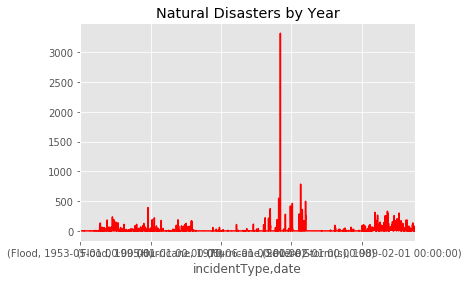

In [68]:
ts_natdisasters = df.groupby(['incidentType']).resample(freq).count()['id']
ts_natdisasters.plot.line(color='red')
plt.title('Natural Disasters by Year')
plt.savefig('natdisasters-by-year')
plt.show()

In [69]:
natdisasters

['Severe Storm(s)', 'Hurricane', 'Flood']

In [70]:
#natdisasters.drop('Biological')

In [71]:
# Severe Storm(s)

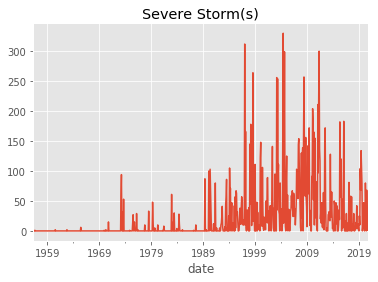

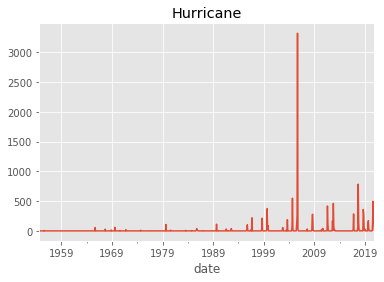

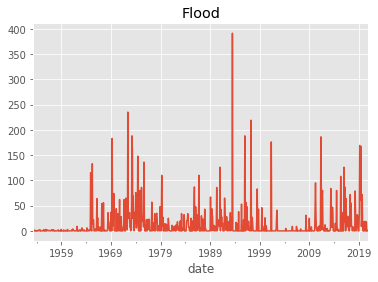

In [72]:
sstorms = {}
for disaster in natdisasters:
    ts = ts_natdisasters[disaster].asfreq(freq).rename(disaster)
    plt.figure()
    ts.plot(title=disaster)
    sstorms[disaster] = ts

In [73]:
df = pd.DataFrame(sstorms) 
df

,Severe Storm(s),Hurricane,Flood
date,,,
1953-05-01,nan,nan,1
1953-06-01,nan,nan,3
1953-07-01,nan,nan,0
1953-08-01,nan,nan,0
1953-09-01,nan,nan,0
...,...,...,...
2020-07-01,68.000,117.000,18
2020-08-01,23.000,497.000,0
2020-09-01,1.000,201.000,0


In [74]:
#sstorms = sstorms.drop(['Biological']) 

In [75]:
df.fillna(0, inplace=True)

In [76]:
df.index

DatetimeIndex(['1953-05-01', '1953-06-01', '1953-07-01', '1953-08-01',
               '1953-09-01', '1953-10-01', '1953-11-01', '1953-12-01',
               '1954-01-01', '1954-02-01',
               ...
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01'],
              dtype='datetime64[ns]', name='date', length=811, freq='MS')

In [77]:
df = df.loc['1970-01-01':'2020-01-01']

# Vizualizations for Non-Technical Audience

In [78]:
#df['Fire']

In [79]:
# Look at Lab for sampling
# MS or ME

In [80]:
## Making into df after running for loop
## Rewatching office hours video - forcasting
## Deleting biological
## Specific periods of time of year

In [81]:
# sstorms = df[df['incidentType'] == 'Severe Storm(s)']
# sstorms

In [82]:
#ts_sstorms = sstorms.resample('A').count()['id']
#ts_sstorms.plot.line(color='red')
##plt.savefig('severestorms-by-year')
#plt.show()

In [83]:
#hurricanes = df[df['incidentType'] =='Hurricane']
#hurricanes

In [84]:
#hurricanes.nunique()

In [85]:
#ts_hurricanes = hurricanes.resample('A').count()['id']
#ts_hurricanes.plot.line(color='purple')
#plt.title('Hurricanes by Year')
#plt.savefig('hurricanes-by-year')
#plt.show()

In [86]:
# Plotting the cumulation of hurricanes
#ts_hurricanes.cumsum().plot()

In [87]:
# Flood

In [88]:
#floods = df[df['incidentType'] =='Flood']
#floods

In [89]:
#ts_flood = floods.resample('A').count()['id']
#ts_flood.plot.line(color='blue')
#plt.title('Floods by Year')
#plt.savefig('floods-by-year')
#plt.show()

In [90]:
# Biological

In [91]:
#Biological = df[df['incidentType'] =='Biological']
#Biological

In [92]:
#ts_Biological = Biological.resample('MS').count()['id']
#ts_Biological.plot.line(color='orange')
#plt.title('Biological by Year')
#plt.savefig('Biological-by-year')
#plt.show()

In [93]:
# Bio is COVID
# Not include in this model

In [94]:
# Snow

In [95]:
#Snow = df[df['incidentType'] =='Snow']
#Snow

In [96]:
#ts_Snow = Snow.resample('A').count()['id']
#ts_Snow.plot.line(color='orange')
#plt.title('Snow by Year')
#plt.savefig('Snow-by-year')
#plt.show()

In [97]:
#'Fire'

In [98]:
#Fire = df[df['incidentType'] =='Fire']
#Fire

In [99]:
#ts_Fire = Fire.resample('A').count()['id']
#ts_Fire.plot.line(color='red')
#plt.title('Fire by Year')
#plt.savefig('Fire-by-year')
#plt.show()

In [100]:
#'Severe Ice Storm'

In [101]:
#Ice = df[df['incidentType'] =='Severe Ice Storm']
#Ice

In [102]:
#ts_Ice = Ice.resample('A').count()['id']
#ts_Ice.plot.line(color='blue')
#plt.title('Ice by Year')
#plt.savefig('Ice-by-year')
#plt.show()

In [103]:
#'Tornado'

In [104]:
#Tornado = df[df['incidentType'] =='Tornado']
#Tornado

In [105]:
#ts_Tornado = Tornado.resample('A').count()['id']
#ts_Tornado.plot.line(color='orange')
#plt.title('Tornado by Year')
#plt.savefig('Tornado-by-year')
#plt.show()

# Modeling

In [106]:
# One of the most common methods used in time series forecasting is known as the ARIMA model, 
# which stands for AutoregRessive Integrated Moving Average. 
# ARIMA is a model that can be fitted to time series data in order to 
# better understand or predict future points in the series.

In [107]:
# Defining (p,d,q)
# p = auto-regressive part of model. Incorporates the effect of past values into our model.
# d = Integrated component of an ARIMA model. Concerned with the amount of differencing 
# as it identifies the number of lag values to subtract from the current observation.  
# q = Moving average part of the model. Used to set the error of the model as a 
# linear combination of the error values observed at previous time point in the past.
# ARIMA(p,d,q) = seasonality, trend, and noise in datasets

In [108]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [109]:
df

,Severe Storm(s),Hurricane,Flood
date,,,
1970-01-01,0.000,0.000,0
1970-02-01,0.000,0.000,44
1970-03-01,0.000,0.000,0
1970-04-01,2.000,0.000,0
1970-05-01,0.000,0.000,0
...,...,...,...
2019-09-01,0.000,172.000,72
2019-10-01,8.000,42.000,7
2019-11-01,25.000,0.000,0


In [110]:
ts_natdisasters = df['Severe Storm(s)']
ts_natdisasters

date
1970-01-01    0.000
1970-02-01    0.000
1970-03-01    0.000
1970-04-01    2.000
1970-05-01    0.000
              ...  
2019-09-01    0.000
2019-10-01    8.000
2019-11-01   25.000
2019-12-01   47.000
2020-01-01    8.000
Freq: MS, Name: Severe Storm(s), Length: 601, dtype: float64

In [111]:
#ans = []
#for comb in pdq:
    #for combs in pdqs:
     #   try:
      #      mod = sm.tsa.statespace.SARIMAX(ts_natdisasters,
       #                                     order=comb,
        ##                                   enforce_stationarity=False,
                         #                   enforce_invertibility=False)

        #    output = mod.fit()
       #     ans.append([comb, combs, output.aic])
      #      print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
     #   except:
     #       continue

In [112]:
#ans_df.to_csv('Best_Params_SS.csv')

In [113]:
# Time Series for Hurricanes
ts_hurricane = df['Hurricane']
ts_hurricane

date
1970-01-01     0.000
1970-02-01     0.000
1970-03-01     0.000
1970-04-01     0.000
1970-05-01     0.000
               ...  
2019-09-01   172.000
2019-10-01    42.000
2019-11-01     0.000
2019-12-01     0.000
2020-01-01     0.000
Freq: MS, Name: Hurricane, Length: 601, dtype: float64

In [114]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_hurricane,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7707.806537209262
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7546.857252716194
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =7405.9416064630295
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =7844.906455113371
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =7405.51243673651
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =7260.067622644535
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =8299.441228174259
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =7587.948831232198
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =7183.220411168228
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =7556.673503252026
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =7545.708373807043
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =7405.5806444744485
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =7594.83804268484
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7403.905353331857
ARIMA (0, 0, 0) x (1

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =7523.342191725866
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =7383.375117085496
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =7590.579392859385
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =7388.848521621234
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =7242.216275643831
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =7878.5889391449955
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =7468.247963932055
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =7171.68401782752
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =7404.895578132118
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =7406.8947139346055
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =7383.807904473946
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =7374.475634661978
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =7270.1898772077
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =7244.211031791843
ARIMA (0, 1, 1) x (2,

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =7491.025462049294
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =7455.52982673157
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =7545.764514274702
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =7513.258548201423
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =7460.688431838101
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =7890.651678601827
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =7540.323575427599
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =7799.801271596765
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7701.437349527218
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7542.066728345053
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =7401.166029051628
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =7842.84663322575
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =7404.090364272639
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =7258.458615273121
ARIMA (1, 0, 0) x (0, 

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =7378.904570079112
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =7825.381947398813
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =7388.096969900125
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =7242.228153842178
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =8278.491475947987
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =7571.572327205555
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =7172.058831411767
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =7530.1831064600965
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =7520.201100889621
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =7380.327386439682
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =7574.828079540535
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =7387.48818507324
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =7241.290699930384
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =7860.794022479908
ARIMA (1, 1, 1) x (1

ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =7694.716490210506
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =7596.851291703345
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =7445.29434090012
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =8067.581145355228
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =7948.7131629246105
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =7426.1911855540875
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =7459.521779067202
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =7461.42491229944
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =7438.5215508190195
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =7509.403757444667
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =7475.805652055627
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =7447.620057705621
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =7847.658209458987
ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =7758.635906044268
ARIMA (1, 2, 2) x (

ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =7492.987154507324
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =7388.457868714476
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =7387.969958338075
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =7668.110491255457
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =7387.742239808758
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =7306.883353815366
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =7678.360366983482
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =7521.2347917024545
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =7380.793236124279
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =7826.986494365743
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =7389.801645462785
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =7243.952764021396
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =8280.125160955347
ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =7573.211235256654
ARIMA (2, 1, 1) x (

ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =7583.80065081238
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =7391.485699582481
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =8323.042559501559
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =7942.793786956828
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =7736.221220667192
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =7584.110485562744
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =7577.556051637209
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =7428.588465890503
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =7667.700095633952
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =7585.850660910006
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =7428.8123362393935
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =8036.132777100014
ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =7930.231199332237
ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =7744.659332235609
ARIMA (2, 2, 2) x (2

In [115]:
ans_df.to_csv('Best_Params_Hurr.csv')

NameError: name 'ans_df' is not defined

In [122]:
# Time Series for Floods
ts_floods = df['Flood']
ts_floods

date
1970-01-01     0
1970-02-01    44
1970-03-01     0
1970-04-01     0
1970-05-01     0
              ..
2019-09-01    72
2019-10-01     7
2019-11-01     0
2019-12-01     0
2020-01-01    18
Freq: MS, Name: Flood, Length: 601, dtype: int64

In [ ]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_floods,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6059.660139208426
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5931.127607426011
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =5800.997903191468
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6201.742506311479
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5743.466547185017
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =5610.443760293486
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =6708.76378791585
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =5988.215781996543
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =5552.253040502221
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5933.372105107444
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5859.470316039189
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =5744.624534444994
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5919.757412143902
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5745.465932085417
ARIMA (0, 0, 0) x (1,

ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =5832.872927057484
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =5815.303646732051
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =5684.214045312305
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =5918.440708956155
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =5717.009529008748
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =5561.7140646447415
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =6219.313894256563
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =5833.803826851433
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =5525.52854306562
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =5717.010030393033
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =5702.103298509301
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =5684.459858719934
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =5722.700747746108
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =5599.909119894999
ARIMA (0, 1, 1) x (2

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =5792.300310258999
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =5765.520517378209
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =5839.5759519904495
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =5847.529579278457
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =5855.67066414114
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =5935.204652415248
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =6274.463075474393
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =6159.562592128562
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6012.423199726136
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5896.8095743917165
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =5774.15242081147
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6202.057033035464
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5737.274653632552
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =5604.646864061202
ARIMA (1, 0, 0) x (0

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =5696.720496961663
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =6189.98196661405
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =5714.988253884831
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =5580.743413560353
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =6696.289524328179
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =5980.240817828845
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =5522.849548025757
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =5820.2408738045
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =5796.852768719262
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =5680.13113734131
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =5903.150073333108
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =5716.844303359912
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =5560.846115020402
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =6207.182346563605
ARIMA (1, 1, 1) x (1, 2,

ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =6054.684882335656
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =5713.202773928114
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =5713.701787156415
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =6213.732011286911
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =5826.558944357335
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =5897.229972819956
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =5767.423426597683
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =5769.700316460943
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =5753.174348217058
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =5754.920560830269
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =5859.106325340968
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =5819.649292964024
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =6142.100817994486
ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =6223.26047699363
ARIMA (1, 2, 2) x (2,

ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =5694.949109314518
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =5671.555760621855
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =6013.931596799502
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =5737.2086606998455
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =5634.67102792975
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =5922.475897926677
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =5812.735871738825
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =5698.687855693603
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =6190.232600147068
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =5716.753681562781
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =5582.596582041498
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =6693.890680231529
ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =5980.4812164314735
ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =5711.943914097585
ARIMA (2, 1, 1) x (

In [ ]:
ans_df.to_csv('Best_Params_Floods.csv')

# Severe Storms

In [ ]:
#1
dfSS = pd.read_csv(r"Best_Params_SS.csv")
dfSS.head()

In [112]:
# Functions to make: best_params, make_best_model (can be combined to one)
# Project Office Hours 3 for forcasting

In [113]:
#2 # Find the parameters with minimal AIC value
dfSS = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
best_params = dict(dfSS.loc[dfSS['aic'].idxmin()])
best_params

{'pdq': (0, 1, 2), 'pdqs': (0, 2, 2, 12), 'aic': 5840.510803675738}

In [116]:
print(best_params['pdq'])
print(best_params['pdqs'])

(0, 2, 2, 12)

In [117]:
#3... is the optimal parameter values that we will now use for our SARIMAX model

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts_natdisasters, 
                                        order=best_params['pdq'], 
                                        seasonal_order=best_params['pdqs'], 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                    Severe Storm(s)   No. Observations:                  601
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 12)   Log Likelihood               -2915.255
Date:                            Tue, 29 Dec 2020   AIC                           5840.511
Time:                                    21:55:34   BIC                           5862.051
Sample:                                01-01-1970   HQIC                          5848.929
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8306      0.031    -26.870      0.000      -0.891      -0.770
ma.L2         -0.0939      0.032     -2.922      0.003      -0.157      -0.031
ma.S.L12      -1.9271      0.031    -63.013      0.000      -1.987      -1.867
ma.S.L24       0.9271      0.029     31.465      0.000       0.869       0.985
sigma2      2029.9171   2.85e-05   7.12e+07      0.000    2029.917    2029.917
===================================================================================
Ljung-Box (Q):                       50.75   Jarque-Bera (JB):              1570.51
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):              24.39   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.08e+22. Standard errors may be unstable.
"""

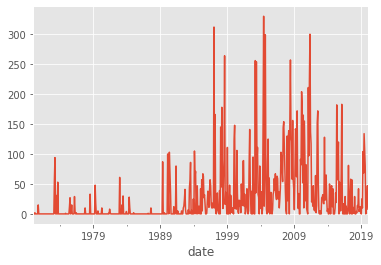

In [118]:
#4
ts_natdisasters.plot()

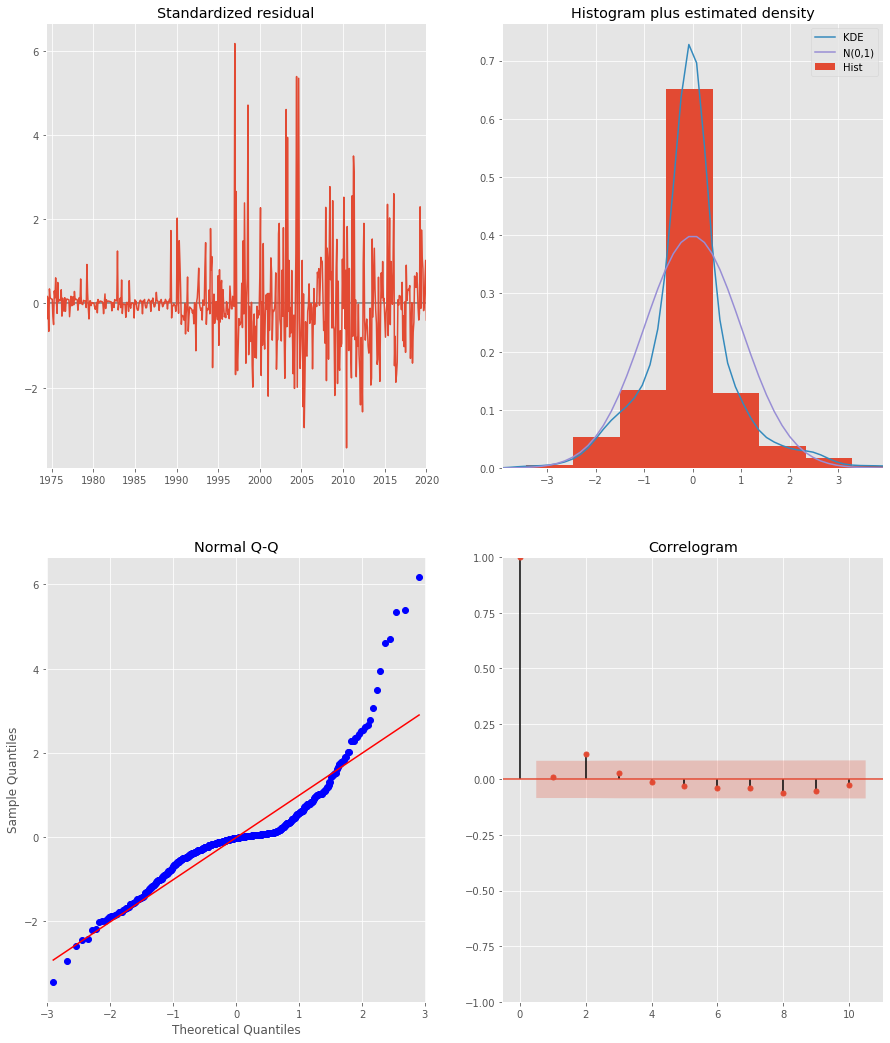

In [119]:
# 5 Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# The Histogram KDE line and N(0,1) are not matching well at all. 
# This is an indication that the resuduals are not normally distrubuted.
# The QQ plot is not the worst but we could find some improvements
# Standarized residual is not bad except for one spot where there is obvious noise

In [125]:
# 6 Get predictions starting from 01-01-2010 and calculate confidence intervals
# Make more recent 
pred = output.get_prediction(start_date=('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

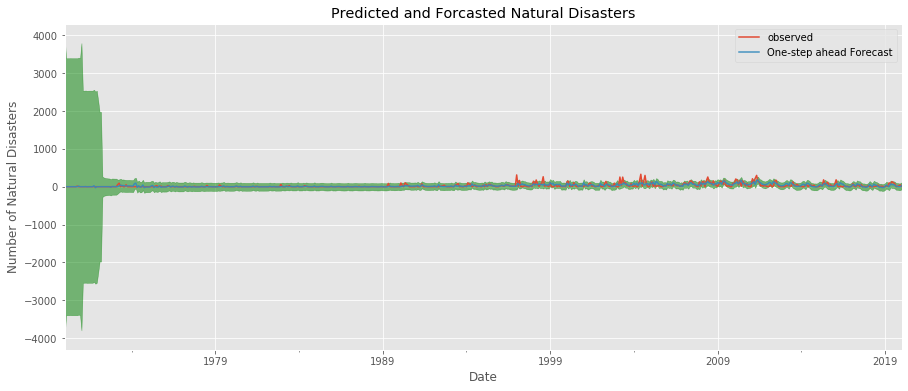

In [126]:
# 7 Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ts_natdisasters.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Natural Disasters')
ax.legend()
ax.set_title('Predicted and Forcasted Natural Disasters')

plt.show()

In [127]:
# 8 Get the real and predicted values
natdisasters_forecasted = pred.predicted_mean
natdisasters_truth = ts_natdisasters['2017-01-01':]

# Compute the mean square error
mse = ((natdisasters_forecasted - natdisasters_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1313.87


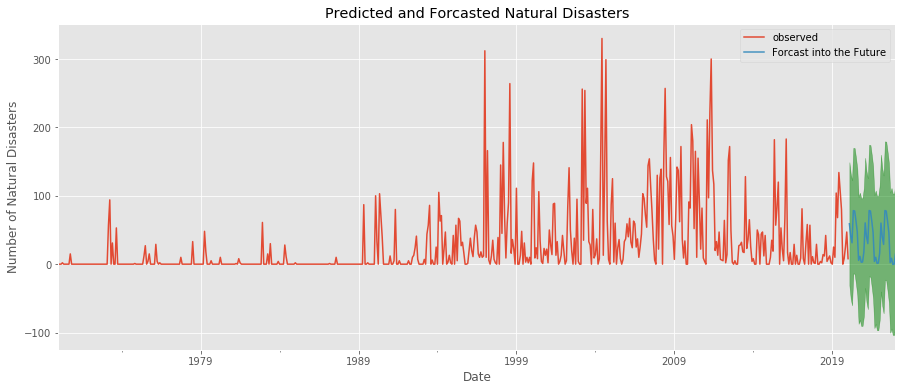

In [129]:
# 9 Forecast 2-3 years, by month
pred = output.get_forecast(steps=36)
pred_conf = pred.conf_int()

# Plot observed values
ax = ts_natdisasters.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forcast into the Future', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Severe Storms')
ax.legend()
ax.set_title('Predicted and Forcasted Severe Storms')

plt.show()

In [ ]:
# 9 Forecast 2-3 years, by month
def plot_prediction(pred, ts_natdisasters, forecast_label = 'prediction'):
    
    pred_conf = pred.conf_int()

    # Plot observed values
    ax = ts_natdisasters.plot(label='observed')

    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label=forecast_label, alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Natural Disasters')
    ax.legend()
    ax.set_title('Predicted and Forcasted Severe Storms')
    
    fig = ax.get_figure()

    plt.show()
    return fig,ax

In [ ]:
# 10 Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# 11 Plot the dynamic forecast with confidence intervals.

ax = ts_natdisasters['1970':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), natdisasters_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Severe Storms')

plt.legend()
plt.show()

In [ ]:
# 12 Extract the predicted and true values of our time series
natdisasters_forecasted = pred_dynamic.predicted_mean
natdisasters_truth = ts_natdisasters['2017-01-01':]

# Compute the mean square error
mse = ((natdisasters_forecasted - natdisasters_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# 13 Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
# 14 Plot future predictions with confidence intervals
ax = ts_natdisasters.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Severe Storms')

plt.legend()
plt.show()

In [ ]:
# get_forecast : Use for future predictions
# What things will or won't be happening in the near future
# Business case for budgetting for certain ones
# Save the future values in a df (predicted mean) -> to use for recommendations
# 1970 for all or different

# Hurricanes

In [ ]:
#1
dfhurr = pd.read_csv(r"Best_Params_Hurr.csv")
dfhurr.head()

In [118]:
#2 Find the parameters with minimal AIC value
ts_hurricane = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
best_params_hurr = dict(ts_hurricane.loc[ts_hurricane['aic'].idxmin()])
best_params_hurr

{'pdq': (0, 0, 2), 'pdqs': (1, 2, 2, 12), 'aic': 7158.884371483791}

In [120]:
#3... is the optimal parameter values that we will now use for our SARIMAX model

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts_hurricane, 
                                        order=best_params_hurr['pdq'], 
                                        seasonal_order=best_params_hurr['pdqs'], 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

output.summary()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
#4
ts_hurricane.plot()

In [ ]:
#5 Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# 6 Get predictions starting from 01-01-2010 and calculate confidence intervals
# Make more recent 
pred = output.get_prediction(start_date=('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
# 7 Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = ts_hurricane.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Hurricanes')
ax.legend()
ax.set_title('Predicted and Forcasted Hurricanes')

plt.show()

In [ ]:
# 8 Get the real and predicted values
ts_hurricane_forcasted = pred.predicted_mean
ts_hurricane_truth = ts_hurricane['2017-01-01':]

# Compute the mean square error
mse = ((ts_hurricane_forcasted - ts_hurricane_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# 9 Forecast 2-3 years, by month
pred = output.get_forecast(steps=24)
pred_conf = pred.conf_int()

# Plot observed values
ax = ts_hurricane.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forcast into the Future', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Hurricanes')
ax.legend()
ax.set_title('Predicted and Forcasted Hurricanes')

plt.show()

In [ ]:
# 10 Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# 11 Plot the dynamic forecast with confidence intervals.

ax = ts_natdisasters['1970':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), ts_hurricane_forcasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Hurricanes')

plt.legend()
plt.show()

In [ ]:
# 12 Extract the predicted and true values of our time series
hurricanes_forecasted = pred_dynamic.predicted_mean
hurricanes_truth = ts_hurricane['2017-01-01':]

# Compute the mean square error
mse = ((hurricanes_forecasted - hurricanes_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# 13 Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
# 14 Plot future predictions with confidence intervals
ax = ts_hurricane.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Hurricanes')

plt.legend()
plt.show()

# Floods

In [ ]:
# 1
dffloods = pd.read_csv(r"Best_Params_Floods.csv")
dffloods.head()

In [ ]:
# 2 Find the parameters with minimal AIC value
dffloods = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
best_params_floods = dict(dffloods.loc[dffloods['aic'].idxmin()])
best_params_floods

In [ ]:
#3 ... is the optimal parameter values that we will now use for our SARIMAX model

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(dffloods, 
                                        order=best_params['pdq'], 
                                        seasonal_order=best_params['pdqs'], 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

output.summary()

In [ ]:
#4 
dffloods.plot()

In [ ]:
#5 Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
#6 Get predictions starting from 01-01-2010 and calculate confidence intervals
# Make more recent 
pred = output.get_prediction(start_date=('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
#7 Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = dffloods.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Floods')
ax.legend()
ax.set_title('Predicted and Forcasted Floods')

plt.show()

In [ ]:
#8 Get the real and predicted values
ts_floods_forcasted = pred.predicted_mean
ts_floods_truth = dffloods['2017-01-01':]

# Compute the mean square error
mse = ((ts_floods_forcasted - ts_floods_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# 9 Forecast 2-3 years, by month
pred = output.get_forecast(steps=24)
pred_conf = pred.conf_int()

# Plot observed values
ax = dffloods.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forcast into the Future', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Number of Floods')
ax.legend()
ax.set_title('Predicted and Forcasted Floods')

plt.show()

In [ ]:
# 10 Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# 11 Plot the dynamic forecast with confidence intervals.

ax = dffloods['1970':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), ts_floods_forcasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Floods')

plt.legend()
plt.show()

In [ ]:
# 12 Extract the predicted and true values of our time series
ts_floods_forcasted = pred_dynamic.predicted_mean
ts_floods_truth = dffloods['2017-01-01':]

# Compute the mean square error
mse = ((ts_floods_forcasted - ts_floods_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# 13 Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [ ]:
# 14 Plot future predictions with confidence intervals
ax = dffloods.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Floods')

plt.legend()
plt.show()

# Conclusions